# Homework #8 (Due 11/06/2019, 11:59pm)
## Variational Inference for Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name:** Rylan Schaeffer

**Students collaborators:** Dimitris Vamvourellis, Dmitry Vukolov

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
import numpy
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc.optimizers import adam

## Problem Description: Bayesian Neural Network Regression
In Homework #7, you explored sampling from the posteriors of ***Bayesian neural networks*** using HMC. In Lab #8 you'll explore the extent to which HMC can be inefficient or ineffective for sampling from certain types of posteriors. In this homework, you will study variational approximations of BNN posteriors, especially when compared to the posteriors obtained by sampling (in Homework #7). The data is the same as the one for Homework #7.


### Part I: Implement Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #15 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 
<br><br>


In [2]:
# adapted from Lecture 15
def black_box_variational_inference(logprob, D, num_samples):
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2 * np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [3]:
# adapted from lecture 15
def variational_inference(Sigma_W, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D

    # define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    # define the log likelihood
    def log_lklhd(W):
        log_odds = np.matmul(W, x_train) + 10
        p = 1 / (1 + np.exp(-log_odds))
        log_likelihood = y_train * np.log(p)
        return log_likelihood

    # define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    # build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if verbose:
                if t % 250 == 0:
                    var_means = params[:D]
                    var_variance = np.diag(np.exp(params[D:]) ** 2)
                    print("Iteration {} lower bound {}; gradient mag: {}".format(
                        t, -objective(params, t), np.linalg.norm(gradient(params, t))))
                    print('Variational Mean: ', var_means)
                    print('Variational Variances: ', var_variance)
    print("Optimizing variational parameters...")
    # initialize variational parameters
    init_mean = 0 * np.ones(D)
    init_log_std = -1 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    # perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration,
                              callback=callback)

    return variational_params

In [4]:
# adapted from lecture 15
def variational_bernoulli_regression(Sigma_W, x_train, y_train, S=2000, max_iteration=2000, step_size=1e-2,
                                     verbose=True):
    '''perform bayesian regression: infer posterior, visualize posterior predictive, compute log-likelihood'''

    D = Sigma_W.shape[0]

    # approximate posterior with mean-field gaussian
    variational_params = variational_inference(
        Sigma_W=Sigma_W,
        y_train=y_train,
        x_train=x_train,
        S=S,
        max_iteration=max_iteration,
        step_size=step_size,
        verbose=verbose)

    # sample from the variational posterior
    var_means = variational_params[:D]
    var_variance = np.diag(np.exp(variational_params[D:]) ** 2)

    return var_means, var_variance

2. (**Unit Test**) Check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean -0.321 and standard deviation 0.876 (all approximate).
<br><br>

In [5]:
Sigma_W = np.eye(1)
ys = np.array([[1.]])
xs = np.array([[-20]])

In [6]:
variational_mean, variational_variance = variational_bernoulli_regression(
    Sigma_W=Sigma_W,
    x_train=xs,
    y_train=ys,
    S=4000,
    max_iteration=2001,
    step_size=1e-1,
    verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -0.9000607591755687; gradient mag: 1.843344191550512
Variational Mean:  [0.]
Variational Variances:  [[0.13533528]]
Iteration 250 lower bound -0.5308554096777611; gradient mag: 0.04342946499575649
Variational Mean:  [-0.55278621]
Variational Variances:  [[0.3123244]]
Iteration 500 lower bound -0.5495332434781084; gradient mag: 0.024267477526000565
Variational Mean:  [-0.56220134]
Variational Variances:  [[0.29677678]]
Iteration 750 lower bound -0.5123105974402793; gradient mag: 0.10105491669518347
Variational Mean:  [-0.53714465]
Variational Variances:  [[0.30552718]]
Iteration 1000 lower bound -0.5076064397016626; gradient mag: 0.08304561811120983
Variational Mean:  [-0.56753442]
Variational Variances:  [[0.29998762]]
Iteration 1250 lower bound -0.5194934970867114; gradient mag: 0.019093999482919944
Variational Mean:  [-0.56728798]
Variational Variances:  [[0.29148606]]
Iteration 1500 lower bound -0.5539681364821437; gradien

In [7]:
print('Variational Mean: ', variational_mean)
print('Variational Standard Deviation: ', np.sqrt(variational_variance))

Variational Mean:  [-0.58291273]
Variational Standard Deviation:  [[0.55142108]]


### Part II: Approximate the Posterior of a Bayesian Neural Network

In [8]:
import numpy
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc.optimizers import adam

In [9]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = ((architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width'] ** 2 + architecture['width'])
                  )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))

    def forward(self, weights, x):

        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in =  self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        # input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        # additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        # output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
        # output = output.squeeze(1)  # Rylan added
        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''

        if reg_param is None:

            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1) ** 2
                sum_error = np.sum(squared_error)
                return sum_error

            return objective, grad(objective)

        else:

            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1) ** 2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(
                    self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])

            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]


In [10]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

params = {'step_size':1e-3,
          'max_iteration': 6001,
          'random_restarts':1,
          'check_point':200}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [11]:
import pandas as pd


df = pd.read_csv('HW7_data.csv')
print(df.head())
xs = df['x'].values
ys = df['y'].values

     x         y
0 -6.0 -3.380284
1 -5.6 -2.892117
2 -5.2 -2.690059
3 -4.8 -2.040000
4 -4.4 -1.399942


In [12]:
# train the netework
nn.fit(xs.reshape((1, -1)), ys.reshape((1, -1)), params)

Iteration 0 lower bound 65.11668053773148; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.864360467566954; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.31175187956584
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.1925753228009
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190933
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044

1. (**Variational Inference for BNNs**) We will implement the following Bayesian model for the data:
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}
  where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases). Just as in HW #7, use a network with a single hidden layer, 5 hidden nodes and rbf activation function.

  Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
  
  ***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.

We first define the log joint distribution and then drop all terms that do not depend on W:

\begin{align}
\log P(W, Y|X)
&= \log \big[p(W) \prod_{n=1}^N p(Y^{(n)} | X^{(n)}, W) \big]\\
&= \log p(W) + \sum_{n=1}^N \log p(Y^{(n)} | X^{(n)}, W)\\
&= -\frac{1}{2} \log (2\pi) - \frac{1}{2} \log |\Sigma| -\frac{1}{2} W^T (5^2 I)^{-1} W + \sum_{n=1}^N \log p(Y^{(n)} | X^{(n)}, W)\\
&\propto -\frac{1}{2} W^T (5^2 I)^{-1} W + \sum_{n=1}^N \log p(Y^{(n)} | X^{(n)}, W)\\
&= -\frac{1}{2} W^T (5^2 I)^{-1} W + \sum_{n=1}^N -\frac{1}{2} \log (2\pi) - \frac{1}{2} \log |0.5^2| -\frac{1}{2} (Y^{(n)} - \mu^{(n)})^T (0.5^2)^{-1} (Y^{(n)} - \mu^{(n)})\\
&\propto -\frac{1}{2} W^T (5^2 I)^{-1} W + \sum_{n=1}^N -\frac{1}{2} (Y^{(n)} - g_W(X^{(n)}))^T (0.5^2)^{-1} (Y^{(n)} - g_W(X^{(n)}))
\end{align}

In [13]:
def log_joint(W, ys, xs):
    term1 = -0.5 * W @ W.T / 25
    yhats = nn.forward(W, xs.reshape(1, -1))
    diff = (yhats - ys).reshape((-1, 1))  # shape [S*12, 1]
    term2 = -0.5 * 4 * diff.T @ diff
    return term1 + term2

4. (**Approximate the Posterior**) Use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!
  

In [14]:
# adapted from Lecture 15
def black_box_variational_inference(logprob, D, num_samples):
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2 * np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params



In [15]:
# adapted from lecture 15
def variational_nn_inference(Sigma_W, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D

    # define the log prior on the model parameters
    #     def log_prior(W):
    #         constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
    #         exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
    #         log_p_W = constant_W + exponential_W
    #         return log_p_W

    # define the log likelihood
    #     def log_lklhd(W):
    #         log_odds = np.matmul(W, x_train) + 10
    #         p = 1 / (1 + np.exp(-log_odds))
    #         log_likelihood = y_train * np.log(p)
    #         return log_likelihood

    def log_joint(W, ys, xs):
        term1 = -0.5 * W @ W.T / 25
        yhats = nn.forward(W, xs.reshape(1, -1))
        term2 = -0.5 * 4 * np.square(yhats-ys).sum(0).mean()  # given by Weiwei Pan
        return term1 + term2

    # define the log joint density
    #     log_density = lambda w, t: log_lklhd(w) + log_prior(w)
    log_density = lambda w, t: log_joint(w, xs=x_train, ys=y_train)

    # build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if verbose:
                if t % 100 == 0:
                    var_means = params[:D]
                    var_variance = np.exp(params[D:]) ** 2
                    # var_variance = np.diag(np.exp(params[D:]) ** 2)
                    print("Iteration {} lower bound {}; gradient mag: {}".format(
                        t, -objective(params, t), np.linalg.norm(gradient(params, t))))
                    print('Variational Mean: ', var_means)
                    print('Variational Variances: ', var_variance)

    print("Optimizing variational parameters...")
    # initialize variational parameters
    init_mean = 0 * np.ones(D)
    init_log_std = -1 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    # perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration,
                              callback=callback)

    return variational_params


In [16]:
D = 16
Sigma_W = np.eye(D)
num_samples = 5000
max_iterations = 3001
step_size = 1e-2

# infer variational parameters
variational_params = variational_nn_inference(
        Sigma_W=Sigma_W,
        y_train=ys,
        x_train=xs,
        S=num_samples,
        max_iteration=max_iterations,
        step_size=step_size,
        verbose=True)
var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)


Optimizing variational parameters...
Iteration 0 lower bound -41584.59312848022; gradient mag: 10395.301055441883
Variational Mean:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Variational Variances:  [0.13533528 0.13533528 0.13533528 0.13533528 0.13533528 0.13533528
 0.13533528 0.13533528 0.13533528 0.13533528 0.13533528 0.13533528
 0.13533528 0.13533528 0.13533528 0.13533528]
Iteration 100 lower bound -27347.73357743928; gradient mag: 9191.282325617627
Variational Mean:  [ 0.11511876 -0.32719037 -0.60684883  0.53035057 -0.31341777  0.05721407
 -1.26715252 -1.0230179   1.1056109  -1.30416755  0.16331821 -0.70176874
 -0.33945213 -0.43886077 -0.74378072 -0.13426113]
Variational Variances:  [0.48730584 0.05031199 0.12630069 0.09993786 0.04507383 0.27347039
 0.06869778 0.15245972 0.13150871 0.06352707 0.0372509  0.03854145
 0.03896857 0.03962194 0.03770594 0.03096716]
Iteration 200 lower bound -4631.26522814292; gradient mag: 2698.5143414640675
Variational Mean:  [ 0.10381222 -0.330

Iteration 1700 lower bound -1125.8822717163778; gradient mag: 294.754781831957
Variational Mean:  [ 0.82934251 -0.52328143 -0.77997289  0.59057736 -0.53385866 -4.28471339
 -3.51606169 -4.27430165  3.8643902  -3.5484903   1.88072406 -0.62781934
 -1.40556915 -0.9474666  -0.69714892 -0.06041382]
Variational Variances:  [2.14873066e-05 3.01435982e-04 8.02773863e-05 1.61875754e-04
 2.85188928e-04 7.64056628e-05 5.57587995e-04 2.01775441e-04
 3.67616549e-04 5.20289689e-04 5.93094467e-04 6.80989842e-04
 5.95081878e-04 6.90673790e-04 6.74788744e-04 6.30986095e-04]
Iteration 1800 lower bound -1116.5778770693364; gradient mag: 381.0533994061984
Variational Mean:  [ 0.82135311 -0.51722032 -0.80626527  0.58324202 -0.52630944 -4.24401428
 -3.55654593 -4.38591021  3.90910723 -3.5909594   1.91204013 -0.63302974
 -1.4883321  -1.0120479  -0.69999842 -0.09154183]
Variational Variances:  [1.84380658e-05 2.82572437e-04 6.74305076e-05 1.41571580e-04
 2.65769339e-04 7.12437645e-05 5.56322318e-04 1.75398728e

4. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1)))
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.

In [20]:
# sample from the variational posterior
posterior_sample_size = 100
posterior_samples = numpy.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)

# sample from posterior predictive
x_test = numpy.linspace(-8, 8, 100)
y_tests, x_tests = [], []
for posterior_sample in posterior_samples:
    y_test = nn.forward(
        posterior_sample.reshape((1, -1)),
        x_test.reshape((1, -1))).squeeze()
    y_test += numpy.random.normal(loc=0, scale=0.5, size=y_test.shape)
    x_tests.append(x_test)
    y_tests.append(y_test)
x_tests = numpy.concatenate(x_tests)
y_tests = numpy.concatenate(y_tests)

# append MLE
y_mle = nn.forward(nn.weights, x_test.reshape((1, -1))).squeeze()

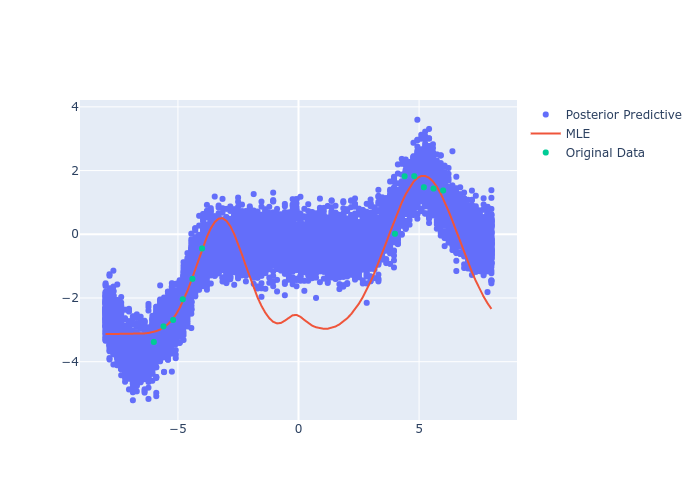

In [21]:
# plot posterior predictive

from IPython.display import Image
import plotly.graph_objects as go
import plotly.io as pio

plot_data = [
    go.Scatter(x=x_tests, y=y_tests, mode='markers', name='Posterior Predictive'),
    go.Scatter(x=x_test, y=y_mle, name='MLE'),
    go.Scatter(x=xs, y=ys, mode='markers', name='Original Data')]
fig = go.Figure(data=plot_data)
# fig.show()
Image(pio.to_image(fig, format='png'))

5. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 

In [22]:
from scipy.stats import norm


log_likelihoods = np.zeros(posterior_samples.shape[0])
for i, posterior_sample in enumerate(posterior_samples):
    y_mean = nn.forward(
        posterior_sample.reshape((1, -1)),
        xs.reshape((1, -1))).squeeze()
    log_like = norm.logpdf(ys, loc=y_mean, scale=0.5)
    log_likelihoods[i] = log_like.sum()
print('Posterior Predictive Log Likelihood: ', numpy.mean(log_likelihoods))

Posterior Predictive Log Likelihood:  -4.937597984226093


6. (**Model Evaluation**) Compare the posterior predictive visualization and the posterior predictive log likelihood obtained from BBVI with the reparametrization trick to the ones you obtained in HW #7. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?

Compared against Homework 7's Hamiltonian Monte Carlo posterior samples, it appears that BBVI is a better model based on its more positive posterior predictive log likelihood (approximately -4.9 versus HMC's -8.72). In fairness, I'm not sure that this is a meaningful conclusion since the competition doesn't have comparable parameters. What I mean by this is that for HMC, I generated 10000 total samples, and took 50 steps per leapfrog step, whereas for BBVI, I generated 4000 samples and optimized for 3000 iterations, and I don't know how to compare these parameters against each other. Was equivalent computational work performed? I don't know.

Empirically, I can say that it appears neither model converged. HMC's trace plots were still trending, while BBVI's lower bound was still increasing and its gradients still large.

Subjectively, I think that HMC provided a better posterior approximation. I say this because although both HMC and BBVI have low aleatoric uncertainty near known points (x=-5, x=5), HMC generated a very wide posterior predictive distribution in the range $x \in [-3, 3]$, which accords with our intuition that we should have high epistemic uncertainty because we have no data in this range. In contrast, BBVI has much lower uncertainty in the range $x \in [-3, 3]$, which makes me concerned.